In [1]:
using RigidBodyDynamics
using ForwardDiff
using Plots
using MeshCatMechanisms

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
# type for system model
struct Model
    f::Function # continuous dynamics (ie, differential equation)
    n::Int # number of states
    m::Int # number of controls

    function Model(f::Function, n::Int64, m::Int64)
        # construct a model from an explicit differential equation
        new(f,n,m)
    end

    function Model(mech::Mechanism)
        # construct a model using robot dynamics equation assembed from URDF file
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\u - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, m)
    end
    
    function Model(mech::Mechanism,torques::Array{Float64,1})
        # underactuated system
        
        # construct a model using robot dynamics equation assembed from URDF file
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\(torques.*u) - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, convert(Int,sum(torques)))
    end
end

function Model(urdf::String)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech)
end

function Model(urdf::String,torques::Array{Float64,1})
    # underactuated system
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech,torques)
end

Model

In [3]:
# cost function
struct Objective
    Q::Array{Float64,2}
    R::Array{Float64,2}
    Qf::Array{Float64,2}
    tf::Float64
    x0::Array{Float64,1}
    xf::Array{Float64,1}
end

In [4]:
struct Solver
    model::Model
    obj::Objective
    dt::Float64
    fd::Function  # discrete dynamics
    F::Function
    N::Int
    function Solver(model::Model, obj::Objective, dt::Float64)
        # RK4 integration
        fd = rk4(model.f, dt)
        F(x,u) = Jacobian(fd,x,u)
        N = Int(floor(obj.tf/dt))
        new(model, obj, dt, fd, F, N)
    end
end

function rk4(f::Function,dt::Float64)
    # Runge-Kutta 4
    k1(x,u) = dt*f(x,u)
    k2(x,u) = dt*f(x + k1(x,u)/2.,u)
    k3(x,u) = dt*f(x + k2(x,u)/2.,u)
    k4(x,u) = dt*f(x + k3(x,u), u)
    fd(x,u) = x + (k1(x,u) + 2.*k2(x,u) + 2.*k3(x,u) + k4(x,u))/6.
end

function midpoint(f::Function,dt::Float64)
    fd(x,u) = x + f(x + f(x,u)*dt/2., u)*dt
end

function Jacobian(f::Function,x::Array{Float64,1},u::Array{Float64,1})
    f1 = a -> f(a,u)
    f2 = b -> f(x,b)
    fx = ForwardDiff.jacobian(f1,x)
    fu = ForwardDiff.jacobian(f2,u)
    return fx, fu
end

Jacobian (generic function with 1 method)

In [5]:
#iLQR
function rollout(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    X[:,1] = solver.obj.x0
    for k = 1:solver.N-1
        X[:,k+1] = solver.fd(X[:,k],U[:,k])
    end
    return X
end

function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf
    
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf
    
    K = zeros(m,n,N-1)
    d = zeros(m,N-1)
    
    S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        
        Qx = lx + fx'*s
        Qu = lu + fu'*s
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu)))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += d[:,k]'*Qu
        v2 += d[:,k]'*Quu*d[:,k]
        
        k = k - 1;
    end
    return K, d, v1, v2
end

function forwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2},J::Float64,v1,v2,c1::Float64=0.5,c2::Float64=1.0)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X_prev = copy(X)
    J_prev = copy(J)
    U_ = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0

    while J > J_prev || z < c1 || z > c2 
        X[:,1] = solver.obj.x0
        for k = 1:N-1
            U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*d[:,k]
            X[:,k+1] = solver.fd(X[:,k],U_[:,k]);
        end

        J = cost(solver,X,U_)
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, U_, J
end

function solve(solver::Solver)
    U = zeros(solver.model.m, solver.N)
    solve(solver,U)
end
    
function solve(solver::Solver,U::Array{Float64,2},iterations::Int64=100,eps::Float64=1e-3)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X = zeros(n,N)
        
    X = rollout(solver, X, U)
    J_prev = cost(solver, X, U)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, d, v1, v2 = backwardpass(solver,X,U)
        X, U, J = forwardpass(solver,X,U,K,d,J_prev,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 4 methods)

In [6]:
## Simple Pendulum
n = 2 # number of states 
m = 1 # number of controls

function fc(x,u)
    # continuous dynamics (as defined in https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end

#initial and goal conditions
x0 = [0.; 0.]
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 0.3*eye(n)
Qf = 30.0*eye(n)
R = 0.3*eye(m)

#simulation
dt = 0.1
tf = 5.0
pendulum = Model(fc,n,m)
obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(pendulum,obj,dt);

In [7]:
U = zeros(solver.model.m,solver.N)
X_pendulum, U_pendulum = @time solve(solver,U);

Initial Cost: 220.58565836434715

*** Iteration: 1 ***
New cost: 144.2774809157575
- Expected improvement: 123.18518482898475
- Actual improvement: 76.30817744858965
- (z = 0.6194590490287172)

*** Iteration: 2 ***
New cost: 120.41385990893764
- Expected improvement: 36.35286928924406
- Actual improvement: 23.86362100681987
- (z = 0.6564439471599162)

*** Iteration: 3 ***
New cost: 110.56432816432286
- Expected improvement: 14.182907184289936
- Actual improvement: 9.84953174461478
- (z = 0.6944649370282044)

*** Iteration: 4 ***
New cost: 105.34232122536577
- Expected improvement: 7.150233391975179
- Actual improvement: 5.222006938957094
- (z = 0.7303267813352549)

*** Iteration: 5 ***
New cost: 99.49860262731133
- Expected improvement: 10.515380674987892
- Actual improvement: 5.843718598054437
- (z = 0.5557305796788157)

*** Iteration: 6 ***
New cost: 95.94731037478279
- Expected improvement: 6.059589659345009
- Actual improvement: 3.5512922525285404
- (z = 0.5860615078203836)

*** It

New cost: 58.7295787746598
- Expected improvement: 0.06451578394617719
- Actual improvement: 0.0346648388950328
- (z = 0.5373078768437848)

*** Iteration: 55 ***
New cost: 58.71741170099006
- Expected improvement: 0.02289555029735337
- Actual improvement: 0.012167073669736794
- (z = 0.5314165203158824)

*** Iteration: 56 ***
New cost: 58.71327830209841
- Expected improvement: 0.007828557143210157
- Actual improvement: 0.004133398891653428
- (z = 0.5279898729791347)

*** Iteration: 57 ***
New cost: 58.71190038183729
- Expected improvement: 0.002619553032350669
- Actual improvement: 0.00137792026112038
- (z = 0.5260135008161665)

*** Iteration: 58 ***
New cost: 58.71144599695815
- Expected improvement: 0.0008656942604191344
- Actual improvement: 0.0004543848791414007
- (z = 0.5248791633681454)

-----SOLVED-----
eps criteria met at iteration: 58
  6.709057 seconds (7.51 M allocations: 351.238 MiB, 1.68% gc time)


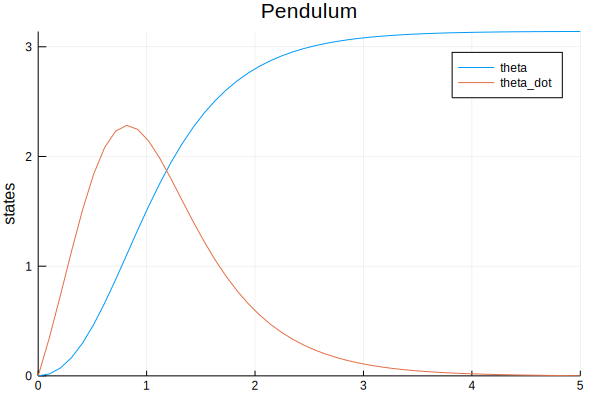

In [8]:
P = plot(linspace(0,tf,solver.N),X_pendulum[1,:],label="theta")
P = plot!(linspace(0,tf,solver.N),X_pendulum[2,:],label="theta_dot",title="Pendulum",ylabel="states")

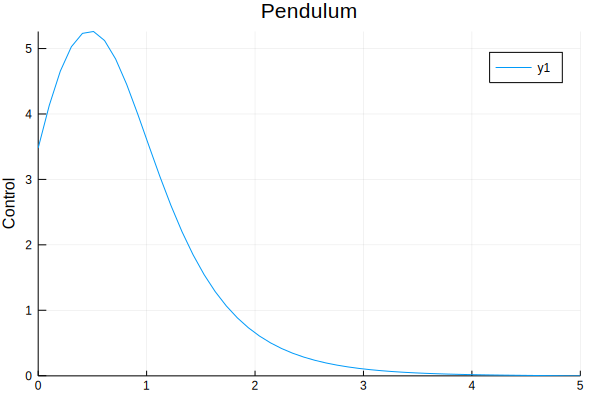

In [9]:
plot(linspace(0,tf,solver.N),[U_pendulum[1,:]; U_pendulum[1,end]],title="Pendulum",ylabel="Control")

In [55]:
plt = plot()
@gif for i=1:size(X_pendulum,2)
    x = cos(X_pendulum[1,i] - pi/2)
    y = sin(X_pendulum[1,i] - pi/2)
    plt = plot([0,x],[0,y],xlims=(-1.5,1.5),ylims=(-1.5,1.5),color="black",size=(200,200),label="",title="Pendulum")
end 

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR demos\tmp.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR demos\\tmp.gif")

In [11]:
# Dubins car parallel park
n = 3 # number of states
m = 2 # number of controls

function fc(x,u)
    return [u[1]*cos(x[3]); u[1]*sin(x[3]); u[2]]
end

# initial and goal states
x0 = [0.;0.;0.]
xf = [0.;1.;0.]

# costs
Q = 0.001*eye(n)
Qf = 1000.0*eye(n)
R = 0.001*eye(m)

# simulation
tf = 5.0
dt = 0.01

car = Model(fc,n,m)
obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(car,obj,dt);

In [12]:
U = 1.0*rand(solver.model.m,solver.N)
X_car, U_car = @time solve(solver,U);

Initial Cost: 3520.5097321653193

*** Iteration: 1 ***
New cost: 1012.5555960228372
- Expected improvement: 4399.896832810362
- Actual improvement: 2507.954136142482
- (z = 0.5700029413054596)

*** Iteration: 2 ***
New cost: 191.45610213230583
- Expected improvement: 1264.6394139775039
- Actual improvement: 821.0994938905314
- (z = 0.6492755838662622)

*** Iteration: 3 ***
New cost: 49.199510629397174
- Expected improvement: 238.7248871307131
- Actual improvement: 142.25659150290866
- (z = 0.5959018065218163)

*** Iteration: 4 ***
New cost: 12.871584819076565
- Expected improvement: 60.99844336571757
- Actual improvement: 36.32792581032061
- (z = 0.5955549651081371)

*** Iteration: 5 ***
New cost: 3.54565175738217
- Expected improvement: 15.624523958815354
- Actual improvement: 9.325933061694395
- (z = 0.5968779008100726)

*** Iteration: 6 ***
New cost: 1.1552269291822523
- Expected improvement: 3.9901829736970313
- Actual improvement: 2.390424828199918
- (z = 0.5990764944759196)

*** 

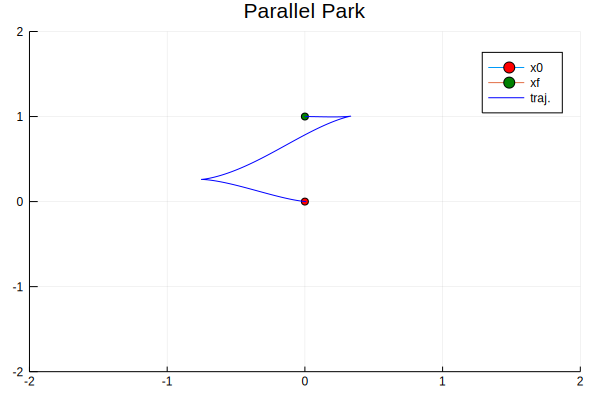

In [13]:
plot((x0[1],x0[2]),marker=(:circle,"red"),label="x0")
plot!((xf[1],xf[2]),marker=(:circle,"green"),label="xf")
plot!(X_car[1,:],X_car[2,:],title="Parallel Park",label="traj.",color="blue",xlim=(-2,2),ylim=(-2,2))

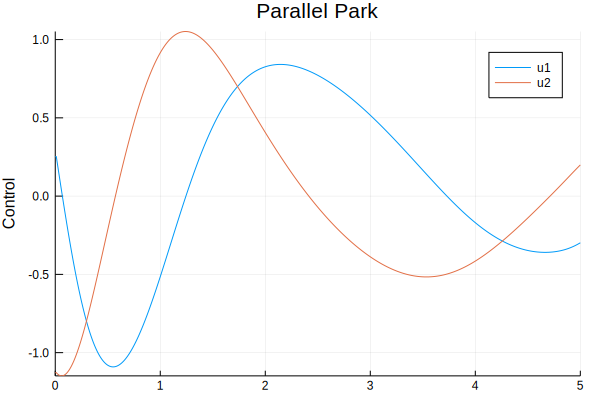

In [14]:
W = plot(linspace(0,tf,solver.N),[U_car[1,1] U_car[1,:]']',title="Parallel Park",label="u1")
W = plot!(linspace(0,tf,solver.N),[U_car[2,1] U_car[2,:]']',ylabel="Control",label="u2")

In [15]:
## Double pendulum
urdf_dp = "doublependulum.urdf"
dp = Model(urdf_dp)

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

# costs
Q = 0.0001*eye(4)
Qf = 250.0*eye(4)
R = 0.0001*eye(2)

# simulation
tf = 5.0
dt = 0.1

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(dp,obj,dt);

In [16]:
U = 10.0*rand(solver.model.m,solver.N)
X_dp, U_dp = @time solve(solver,U);

Initial Cost: 3234.6950533407517

*** Iteration: 1 ***
New cost: 1982.8828221830795
- Expected improvement: 1819.4732044322855
- Actual improvement: 1251.8122311576722
- (z = 0.688008060854221)

*** Iteration: 2 ***
New cost: 1135.2707059143888
- Expected improvement: 1115.2667377216617
- Actual improvement: 847.6121162686907
- (z = 0.7600084245319169)

*** Iteration: 3 ***
New cost: 347.0333726626987
- Expected improvement: 1418.8073339979396
- Actual improvement: 788.2373332516902
- (z = 0.5555633343327748)

*** Iteration: 4 ***
New cost: 65.48740100587344
- Expected improvement: 433.58685745044704
- Actual improvement: 281.54597165682526
- (z = 0.6493415720955105)

*** Iteration: 5 ***
New cost: 18.656843018715623
- Expected improvement: 81.67895885124027
- Actual improvement: 46.83055798715782
- (z = 0.5733491053975)

*** Iteration: 6 ***
New cost: 6.8950208338911985
- Expected improvement: 23.12200069156455
- Actual improvement: 11.761822184824425
- (z = 0.5086853141179696)

*** I

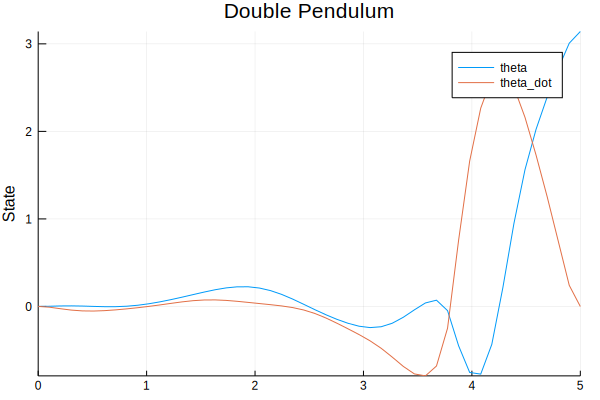

In [17]:
P = plot(linspace(0,tf,solver.N),X_dp[1,:],title="Double Pendulum",label="theta")
P = plot!(linspace(0,tf,solver.N),X_dp[2,:],ylabel="State",label="theta_dot")

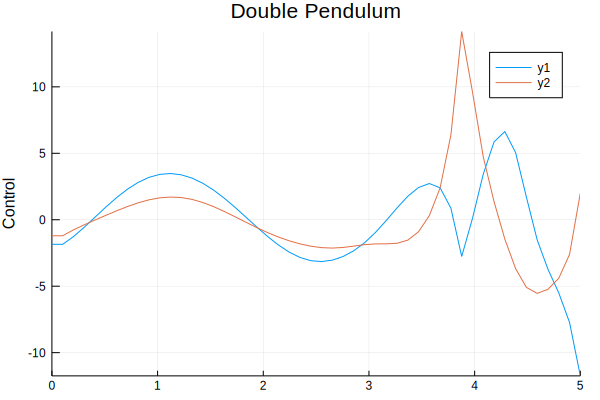

In [18]:
W = plot(linspace(0,tf,solver.N),[U_dp[1,1] U_dp[1,:]']',title="Double Pendulum")
W = plot!(linspace(0,tf,solver.N),[U_dp[2,1] U_dp[2,:]']',ylabel="Control")

In [78]:
vis = MechanismVisualizer(parse_urdf(Float64,urdf_dp),URDFVisuals(urdf_dp));
IJuliaCell(vis)

WebIO.Scope("scope-0e9ef2fd-edbe-4dc0-b4e6-4785ef183cd5", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-2f0b2761-28f5-4878-802a-b2ca949b5957&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-2f0b2761-28f5-4878-802a-b2ca949b5957&quot;,&quot;id&quot;:&quot;ob_56&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_55&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,205,204,204,61,0,0,128,191,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,46,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,98,97,115,101,95,108,105,110,107,47,117,112,112,101,114,95,108,105,110,107,47,108,111,119,101,114,95,108,105,110,107]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_57&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_56&quot;,&quot;va

In [79]:
state = MechanismState(parse_urdf(Float64,urdf_dp))
for i = 1:size(X_dp,2)
    set_configuration!(state, X_dp[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(0.1)
end

In [21]:
## Cartpole (w/ 2 controls)
urdf_cp = "cartpole.urdf"
cp = Model(urdf_cp)

# initial and goal states
x0 = [0.;pi;0.;0.]
xf = [0.;0.;0.;0.]

# costs
Q = 0.001*eye(4)
Qf = 150.0*eye(4)
R = 0.0001*eye(2)

# simulation
tf = 5.0
dt = 0.1

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(cp,obj,dt);

In [48]:
U = 10.0*rand(solver.model.m,solver.N)
X_cp, U_cp = @time solve(solver,U);

Initial Cost: 5815.089569874168

*** Iteration: 1 ***
New cost: 2104.640207987532
- Expected improvement: 7242.211276456623
- Actual improvement: 3710.449361886636
- (z = 0.5123365254406161)

*** Iteration: 2 ***
New cost: 2104.6401509620846
- Expected improvement: 5.7025451319849464e-5
- Actual improvement: 5.70254474041576e-5
- (z = 0.9999999313343118)

-----SOLVED-----
eps criteria met at iteration: 2
109.484046 seconds (422.58 M allocations: 39.917 GiB, 15.97% gc time)


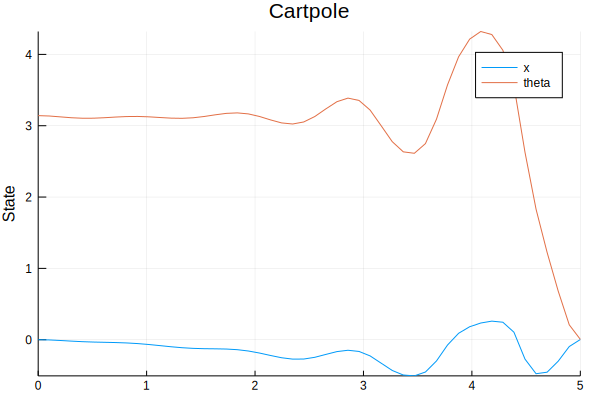

In [23]:
P = plot(linspace(0,tf,solver.N),X_cp[1,:],title="Cartpole",label="x")
P = plot!(linspace(0,tf,solver.N),X_cp[2,:],ylabel="State",label="theta")

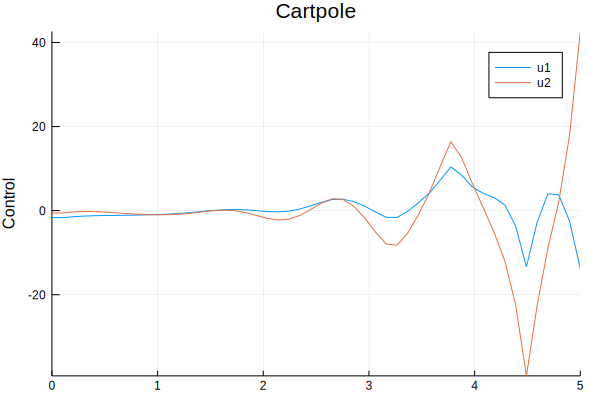

In [24]:
W = plot(linspace(0,tf,solver.N),[U_cp[1,1] U_cp[1,:]']',title="Cartpole",label="u1")
W = plot!(linspace(0,tf,solver.N),[U_cp[2,1] U_cp[2,:]']',ylabel="Control",label="u2")

In [67]:
# vis = MechanismVisualizer(parse_urdf(Float64,urdf_cp),URDFVisuals(urdf_cp));
# IJuliaCell(vis)

WebIO.Scope("scope-6bf5c0e3-9172-4116-9d16-a54b3fad3eb8", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-b5b1fe71-22a1-4fe2-92bc-f15e95acb3d5&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-b5b1fe71-22a1-4fe2-92bc-f15e95acb3d5&quot;,&quot;id&quot;:&quot;ob_38&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_37&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,33,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,115,108,105,100,101,66,97,114,47,99,97,114,116,47,112,111,108,101]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_39&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_38&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&q

In [68]:
# state = MechanismState(parse_urdf(Float64,urdf_cp))
# for i = 1:size(X_cp,2)
#     set_configuration!(state, X_cp[1:2,i])
#     set_configuration!(vis, configuration(state))
#     sleep(0.1)
# end

In [27]:
## Acrobot
# may need to run again if random initialization is bad
urdf_dp = "doublependulum.urdf"
acrobot = Model(urdf_dp,[0.;1.]) # underactuated double pendulum
n = 4
m = 1

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

# costs
Q = 1e-4*eye(n)
Qf = 250.0*eye(n)
R = 1e-4*eye(m)

# simulation
tf = 5.0
dt = 0.01

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(acrobot,obj,dt);

In [28]:
U = 10.0*rand(solver.model.m,solver.N)
X_acrobot, U_acrobot = @time solve(solver,U);

Initial Cost: 3495.013634123073

*** Iteration: 1 ***
New cost: 692.2602694600372
- Expected improvement: 4364.3156828362125
- Actual improvement: 2802.753364663036
- (z = 0.642197670458528)

*** Iteration: 2 ***
New cost: 240.33583810000425
- Expected improvement: 862.2175367238626
- Actual improvement: 451.92443136003294
- (z = 0.524142008381312)

*** Iteration: 3 ***
New cost: 113.01823124350922
- Expected improvement: 133.77815419552107
- Actual improvement: 127.31760685649503
- (z = 0.9517070079350644)

*** Iteration: 4 ***
New cost: 32.99815494683085
- Expected improvement: 138.796874454049
- Actual improvement: 80.02007629667837
- (z = 0.5765265004088427)

*** Iteration: 5 ***
New cost: 22.331349134328622
- Expected improvement: 17.716715484031866
- Actual improvement: 10.66680581250223
- (z = 0.6020758092613869)

*** Iteration: 6 ***
New cost: 18.721735596505095
- Expected improvement: 5.5963061615737
- Actual improvement: 3.6096135378235275
- (z = 0.6449992966089781)

*** Iter

New cost: 0.970275872057683
- Expected improvement: 0.0021033601305489973
- Actual improvement: 0.0013374080225185825
- (z = 0.6358435738579423)

*** Iteration: 52 ***
New cost: 0.9690352812867548
- Expected improvement: 0.0019410926779017687
- Actual improvement: 0.001240590770928196
- (z = 0.6391198035269584)

*** Iteration: 53 ***
New cost: 0.9678800403539811
- Expected improvement: 0.001799479675359399
- Actual improvement: 0.001155240932773638
- (z = 0.6419860966436917)

*** Iteration: 54 ***
New cost: 0.9668004922935992
- Expected improvement: 0.0016750010957110816
- Actual improvement: 0.0010795480603819074
- (z = 0.6445058830983099)

*** Iteration: 55 ***
New cost: 0.9657884396825711
- Expected improvement: 0.0015648737344741087
- Actual improvement: 0.0010120526110281025
- (z = 0.6467311635006852)

*** Iteration: 56 ***
New cost: 0.964836873389578
- Expected improvement: 0.001466871036459353
- Actual improvement: 0.000951566292993089
- (z = 0.6487048072678044)

-----SOLVED----

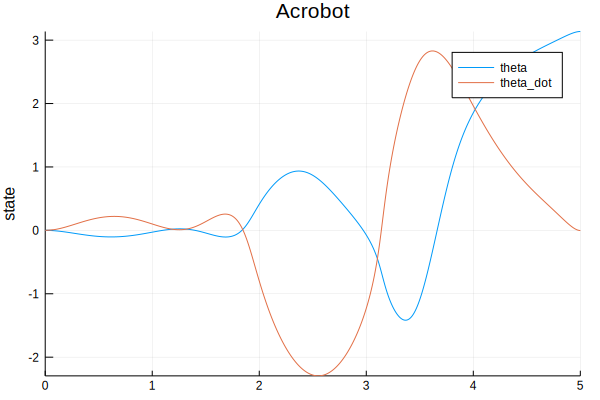

In [29]:
P = plot(linspace(0,tf,solver.N),X_acrobot[1,:],title="Acrobot",label="theta")
P = plot!(linspace(0,tf,solver.N),X_acrobot[2,:],ylabel="state",label="theta_dot")

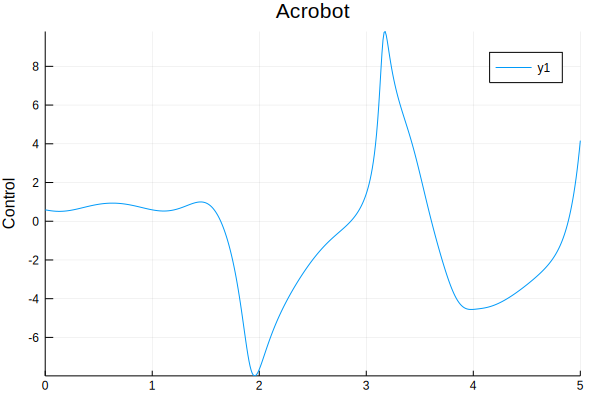

In [30]:
W = plot(linspace(0,tf,solver.N),[U_acrobot[1,1] U_acrobot[1,:]']',title="Acrobot",ylabel="Control")

In [80]:
vis = MechanismVisualizer(parse_urdf(Float64,urdf_dp),URDFVisuals(urdf_dp));
IJuliaCell(vis)

WebIO.Scope("scope-8dc2b540-27ab-42f5-b2bf-f8f6bce0eeb5", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-eb7c6872-451f-45ce-a928-3803be2498d8&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-eb7c6872-451f-45ce-a928-3803be2498d8&quot;,&quot;id&quot;:&quot;ob_59&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_58&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,205,204,204,61,0,0,128,191,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,46,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,98,97,115,101,95,108,105,110,107,47,117,112,112,101,114,95,108,105,110,107,47,108,111,119,101,114,95,108,105,110,107]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_60&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_59&quot;,&quot;va

In [81]:
state = MechanismState(parse_urdf(Float64,urdf_dp))
for i = 1:size(X_acrobot,2)
    set_configuration!(state, X_acrobot[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(dt)
end

In [33]:
## Cartpole (underactuated)
urdf_cp = "cartpole.urdf"
cp = Model(urdf_cp,[1.;0.])
n = 4
m = 1

# initial and goal states
x0 = [0.;pi;0.;0.]
xf = [0.;0.;0.;0.]

# costs
Q = 0.001*eye(n)
Qf = 250.0*eye(n)
R = 0.0001*eye(m)

# simulation
tf = 5.0
dt = 0.01

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(cp,obj,dt);

In [49]:
U = 25.0*rand(solver.model.m,solver.N)
X_cp2, U_cp2 = @time solve(solver,U);

Initial Cost: 30760.95195228593

*** Iteration: 1 ***
New cost: 8058.4315477254695
- Expected improvement: 38423.62283744639
- Actual improvement: 22702.520404560462
- (z = 0.5908479921480839)

*** Iteration: 2 ***
New cost: 6125.6723522852
- Expected improvement: 2130.350248211446
- Actual improvement: 1932.7591954402697
- (z = 0.9072494990262444)

*** Iteration: 3 ***
New cost: 5439.850304455254
- Expected improvement: 746.8214240462629
- Actual improvement: 685.8220478299454
- (z = 0.9183213359281739)

*** Iteration: 4 ***
New cost: 3301.7018930913664
- Expected improvement: 2835.611577506887
- Actual improvement: 2138.148411363888
- (z = 0.7540343072106445)

*** Iteration: 5 ***
New cost: 2216.17067553145
- Expected improvement: 1828.2185953765231
- Actual improvement: 1085.5312175599165
- (z = 0.5937644548114611)

*** Iteration: 6 ***
New cost: 1394.8969407215582
- Expected improvement: 960.4460366050903
- Actual improvement: 821.2737348098917
- (z = 0.8550961777226611)

*** Itera

New cost: 12.335652652813183
- Expected improvement: 0.010091768517647213
- Actual improvement: 0.007234370638961707
- (z = 0.7168585591624651)

*** Iteration: 52 ***
New cost: 12.314368701495916
- Expected improvement: 0.03444223884432003
- Actual improvement: 0.021283951317267125
- (z = 0.617960737496515)

*** Iteration: 53 ***
New cost: 12.304258844724865
- Expected improvement: 0.01917261921611756
- Actual improvement: 0.010109856771050474
- (z = 0.5273070234739535)

*** Iteration: 54 ***
New cost: 12.297765648523542
- Expected improvement: 0.00960849414730654
- Actual improvement: 0.006493196201322604
- (z = 0.6757766723667913)

*** Iteration: 55 ***
New cost: 12.278361167539325
- Expected improvement: 0.03140004391517365
- Actual improvement: 0.019404480984217543
- (z = 0.6179762371236872)

*** Iteration: 56 ***
New cost: 12.269464028891129
- Expected improvement: 0.013484909882288981
- Actual improvement: 0.00889713864819619
- (z = 0.6597848058207383)

*** Iteration: 57 ***
New 

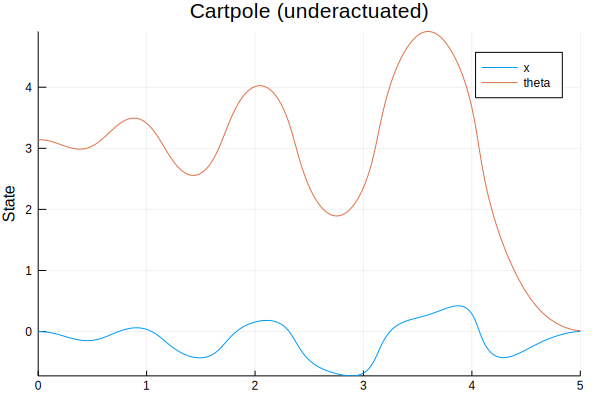

In [50]:
P = plot(linspace(0,tf,solver.N),X_cp2[1,:],title="Cartpole (underactuated)",label="x")
P = plot!(linspace(0,tf,solver.N),X_cp2[2,:],ylabel="State",label="theta")

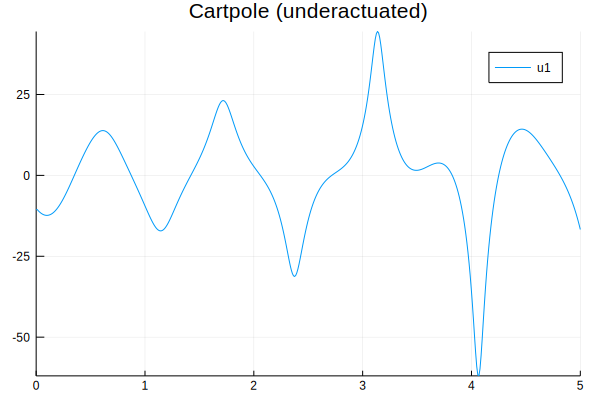

In [51]:
W = plot(linspace(0,tf,solver.N),[U_cp2[1,1] U_cp2[1,:]']',title="Cartpole (underactuated)",label="u1")

In [82]:
vis = MechanismVisualizer(parse_urdf(Float64,urdf_cp),URDFVisuals(urdf_cp));
IJuliaCell(vis)

WebIO.Scope("scope-0c9c985f-0ce2-4f83-b7f7-4edef0c7baee", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-513f78ad-649d-448e-8bd0-10733b7461d0&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-513f78ad-649d-448e-8bd0-10733b7461d0&quot;,&quot;id&quot;:&quot;ob_62&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_61&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,33,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,115,108,105,100,101,66,97,114,47,99,97,114,116,47,112,111,108,101]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_63&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_62&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&q

In [83]:
state = MechanismState(parse_urdf(Float64,urdf_cp))
for i = 1:size(X_cp2,2)
    set_configuration!(state, X_cp2[1:2,i])
    set_configuration!(vis, configuration(state))
    #sleep(0.1)
end